# Classifying Urban sounds using Deep Learning

## 4 Model Refinement 

### Load Preprocessed data 

In [ ]:
# retrieve the preprocessed data from previous notebook

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
%store -r yy 
%store -r le

#### Model refinement

In our inital attempt, we were able to achieve a Classification Accuracy score of: 

* Training data Accuracy:  92.3% 
* Testing data Accuracy:  87% 

We will now see if we can improve upon that score using a Convolutional Neural Network (CNN). 

#### Feature Extraction refinement 

In the prevous feature extraction stage, the MFCC vectors would vary in size for the different audio files (depending on the samples duration). 

However, CNNs require a fixed size for all inputs. To overcome this we will zero pad the output vectors to make them all the same size. 

In [1137]:
import numpy as np
max_pad_len = 174
mfcc_count = 64
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    except OSError:
        return None
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=mfcc_count)
    pad_width = max_pad_len - mfccs.shape[1]
#     if(mfccs.shape[1] < 60):
#         return None
    if(pad_width < 0):
        print(file_name)
        mfccs = mfccs[:,:pad_width].copy()
    else:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
     
    return mfccs


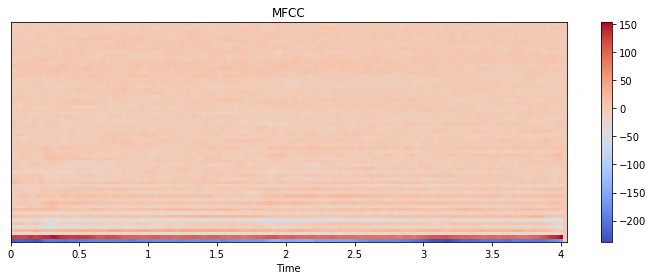

In [1186]:
# feat = extract_features('/home/yutonggu/School/EE542/final_proj/Master Tracks/Ruger Mark III/R_29.wav')
feat = extract_features('/home/yutonggu/School/EE542/final_proj/UrbanSound8K/audio/fold5/13577-3-0-2.wav')

import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10, 4))
librosa.display.specshow(feat, x_axis='time', )
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

46


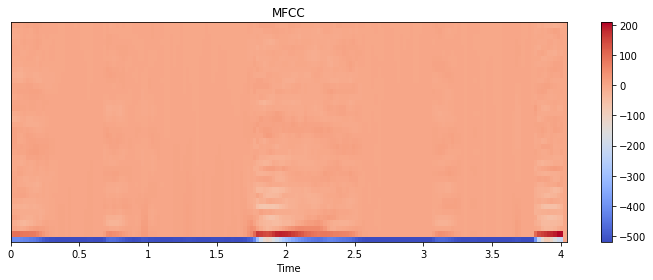

In [1185]:
# index = 0
index +=1 
print(index)
fdf = featuresdf.loc[featuresdf['class_label'] == 'dog_bark'].feature
feat = fdf[fdf.index[index]]
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10, 4))
librosa.display.specshow(feat, x_axis='time', )
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


In [1091]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
fulldatasetpath = '../../../UrbanSound8K/audio/'

metadata = pd.read_csv('../UrbanSound Dataset sample/metadata/UrbanSound8K.csv')

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class_name"]
    data = extract_features(file_name)
    if data is not None:
        features.append([data, class_label])


In [1092]:
# gundatasetpath = '../../../Master Tracks/'

# gunshot_metadata = pd.read_csv(os.path.join(gundatasetpath,'Master Sheet.csv'))

# for index, row in gunshot_metadata.iterrows():
    
#     file_name = os.path.join(os.path.abspath(gundatasetpath),str(row["CD"])+'/',str(row["Filename"])+".wav")
    
#     class_label = "gun_shot"
#     data = extract_features(file_name)
#     if data is not None:
#         features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  17828  files


In [1093]:
print(featuresdf.groupby('class_label').size())
# featuresdf2 = featuresdf.drop(
# featuresdf2 = featuresdf.drop(featuresdf.loc[featuresdf['class_label'] == 'dog_bark'].index)
# featuresdf2 = featuresdf2.drop(featuresdf2.loc[featuresdf2['class_label'] == 'car_horn'].index)
# featuresdf2 = featuresdf2.drop(featuresdf2.loc[featuresdf2['class_label'] == 'jackhammer'].index)
# print(featuresdf2.groupby('class_label').size())

class_label
air_conditioner     2174
car_horn             699
children_playing    2068
dog_bark            1888
drilling            1960
engine_idling       2144
gun_shot             861
jackhammer          2086
siren               1924
street_music        2024
dtype: int64


In [1094]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
# X = np.array(featuresdf.feature.tolist())
# y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

### Convolutional Neural Network (CNN) model architecture 


We will modify our model to be a Convolutional Neural Network (CNN) again using Keras and a Tensorflow backend. 

Again we will use a `sequential` model, starting with a simple model architecture, consisting of four `Conv2D` convolution layers, with our final output layer being a `dense` layer. 

The convolution layers are designed for feature detection. It works by sliding a filter window over the input and performing a matrix multiplication and storing the result in a feature map. This operation is known as a convolution. 


The `filter` parameter specifies the number of nodes in each layer. Each layer will increase in size from 16, 32, 64 to 128, while the `kernel_size` parameter specifies the size of the kernel window which in this case is 2 resulting in a 2x2 filter matrix. 

The first layer will receive the input shape of (40, 174, 1) where 40 is the number of MFCC's 174 is the number of frames taking padding into account and the 1 signifying that the audio is mono. 

The activation function we will be using for our convolutional layers is `ReLU` which is the same as our previous model. We will use a smaller `Dropout` value of 20% on our convolutional layers. 

Each convolutional layer has an associated pooling layer of `MaxPooling2D` type with the final convolutional layer having a `GlobalAveragePooling2D` type. The pooling layer is do reduce the dimensionality of the model (by reducing the parameters and subsquent computation requirements) which serves to shorten the training time and reduce overfitting. The Max Pooling type takes the maximum size for each window and the Global Average Pooling type takes the average which is suitable for feeding into our `dense` output layer.  

Our output layer will have 10 nodes (num_labels) which matches the number of possible classifications. The activation is for our output layer is `softmax`. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

In [1095]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = mfcc_count
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)


print(x_train.size)


num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

99263520


In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

### Compiling the model 

For compiling our model, we will use the same three parameters as the previous model: 

In [1096]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [1097]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_149 (Conv2D)          (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_139 (MaxPoolin (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_134 (Dropout)        (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_135 (Dropout)        (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 8, 41, 64)       

### Training 

Here we will train the model. As training a CNN can take a sigificant amount of time, we will start with a low number of epochs and a low batch size. If we can see from the output that the model is converging, we will increase both numbers.  

In [1098]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

#num_epochs = 12
#num_batch_size = 128

num_epochs = 70
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 14262 samples, validate on 3566 samples
Epoch 1/70
14262/14262 [==============================] - 29s 2ms/step - loss: 2.4627 - accuracy: 0.2197 - val_loss: 1.9963 - val_accuracy: 0.3430

Epoch 00001: val_loss improved from inf to 1.99631, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 2/70
14262/14262 [==============================] - 31s 2ms/step - loss: 1.6899 - accuracy: 0.3952 - val_loss: 1.6580 - val_accuracy: 0.4526

Epoch 00002: val_loss improved from 1.99631 to 1.65800, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 3/70
14262/14262 [==============================] - 29s 2ms/step - loss: 1.4135 - accuracy: 0.4940 - val_loss: 1.4674 - val_accuracy: 0.5283

Epoch 00003: val_loss improved from 1.65800 to 1.46740, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 4/70
14262/14262 [==============================] - 29s 2ms/step - loss: 1.2697 - accuracy: 0.5504 - val_loss: 1.3289 - val_accuracy: 0.5777

Epoch 00004: val_loss im

14262/14262 [==============================] - 29s 2ms/step - loss: 0.4239 - accuracy: 0.8558 - val_loss: 0.4071 - val_accuracy: 0.8738

Epoch 00033: val_loss improved from 0.42762 to 0.40706, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 34/70
14262/14262 [==============================] - 29s 2ms/step - loss: 0.4126 - accuracy: 0.8612 - val_loss: 0.3882 - val_accuracy: 0.8761

Epoch 00034: val_loss improved from 0.40706 to 0.38817, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 35/70
14262/14262 [==============================] - 29s 2ms/step - loss: 0.4070 - accuracy: 0.8631 - val_loss: 0.3941 - val_accuracy: 0.8763

Epoch 00035: val_loss did not improve from 0.38817
Epoch 36/70
14262/14262 [==============================] - 29s 2ms/step - loss: 0.3941 - accuracy: 0.8695 - val_loss: 0.3666 - val_accuracy: 0.8808

Epoch 00036: val_loss improved from 0.38817 to 0.36658, saving model to saved_models/weights.best.basic_cnn.hdf5
Epoch 37/70
14262/14262 [=

14262/14262 [==============================] - 29s 2ms/step - loss: 0.2160 - accuracy: 0.9247 - val_loss: 0.2123 - val_accuracy: 0.9279

Epoch 00069: val_loss did not improve from 0.19700
Epoch 70/70
14262/14262 [==============================] - 29s 2ms/step - loss: 0.2175 - accuracy: 0.9240 - val_loss: 0.1953 - val_accuracy: 0.9372

Epoch 00070: val_loss improved from 0.19700 to 0.19530, saving model to saved_models/weights.best.basic_cnn.hdf5
Training completed in time:  0:33:46.133900


### Test the model 

Here we will review the accuracy of the model on both the training and test data sets. 

In [1099]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9502874612808228
Testing Accuracy:  0.9371845126152039


The Training and Testing accuracy scores are both high and an increase on our initial model. Training accuracy has increased by ~6% and Testing accuracy has increased by ~4%. 

There is a marginal increase in the difference between the Training and Test scores (~6% compared to ~5% previously) though the difference remains low so the model has not suffered from overfitting. 

### Predictions  

Here we will modify our previous method for testing the models predictions on a specified audio .wav file. 

In [1100]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 
    
    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

### Validation 

#### Test with sample data 

As before we will verify the predictions using a subsection of the sample audio files we explored in the first notebook. We expect the bulk of these to be classified correctly. 

In [1101]:
# Class: Air Conditioner

filename = '../UrbanSound Dataset sample/audio/100852-0-0-0.wav' 
print_prediction(filename) 

The predicted class is: air_conditioner 

air_conditioner 		 :  0.99867093563079833984375000000000
car_horn 		 :  0.00000402626710638287477195262909
children_playing 		 :  0.00016055910964496433734893798828
dog_bark 		 :  0.00004336623896961100399494171143
drilling 		 :  0.00048922485439106822013854980469
engine_idling 		 :  0.00000781768994784215465188026428
gun_shot 		 :  0.00000090114116346740047447383404
jackhammer 		 :  0.00061783537967130541801452636719
siren 		 :  0.00000040847228888196696061640978
street_music 		 :  0.00000503597857459681108593940735


In [1102]:
# Class: Drilling

filename = '../UrbanSound Dataset sample/audio/103199-4-0-0.wav'
print_prediction(filename) 

The predicted class is: drilling 

air_conditioner 		 :  0.00000001357421375303147215163335
car_horn 		 :  0.00000168215046869590878486633301
children_playing 		 :  0.00000324878442370390985161066055
dog_bark 		 :  0.00001741812957334332168102264404
drilling 		 :  0.99927097558975219726562500000000
engine_idling 		 :  0.00000000045812095783581696650799
gun_shot 		 :  0.00000000033315758485308322178753
jackhammer 		 :  0.00000002584244818137904076138511
siren 		 :  0.00000001452297837545302172657102
street_music 		 :  0.00070661935023963451385498046875


In [1103]:
# Class: Street music 

filename = '../UrbanSound Dataset sample/audio/101848-9-0-0.wav'
print_prediction(filename) 

The predicted class is: street_music 

air_conditioner 		 :  0.00009937435970641672611236572266
car_horn 		 :  0.00005493377466336823999881744385
children_playing 		 :  0.00683879014104604721069335937500
dog_bark 		 :  0.00048707932000979781150817871094
drilling 		 :  0.00000168109670539706712588667870
engine_idling 		 :  0.00000008667340978263382567092776
gun_shot 		 :  0.00000000002521326029902848375741
jackhammer 		 :  0.00000000032437405539376129581797
siren 		 :  0.00025366042973473668098449707031
street_music 		 :  0.99226450920104980468750000000000


In [1104]:
# Class: Car Horn 

filename = '../UrbanSound Dataset sample/audio/100648-1-0-0.wav'
print_prediction(filename) 

The predicted class is: gun_shot 

air_conditioner 		 :  0.00053320924052968621253967285156
car_horn 		 :  0.27805629372596740722656250000000
children_playing 		 :  0.00111315911635756492614746093750
dog_bark 		 :  0.21885608136653900146484375000000
drilling 		 :  0.09843221306800842285156250000000
engine_idling 		 :  0.01270252466201782226562500000000
gun_shot 		 :  0.31405135989189147949218750000000
jackhammer 		 :  0.05768876150250434875488281250000
siren 		 :  0.01842143759131431579589843750000
street_music 		 :  0.00014494011702481657266616821289


#### Observations 

We can see that the model performs well. 

Interestingly, car horn was again incorrectly classifed but this time as drilling - though the per class confidence shows it was a close decision between car horn with 26% confidence and drilling at 34% confidence.  

### Other audio

Again we will further validate our model using a sample of various copyright free sounds that we not part of either our test or training data. 

In [1105]:
filename = '../Evaluation audio/dog_bark_1.wav'
print_prediction(filename) 

The predicted class is: dog_bark 

air_conditioner 		 :  0.00032920067314989864826202392578
car_horn 		 :  0.00688201608136296272277832031250
children_playing 		 :  0.01028886809945106506347656250000
dog_bark 		 :  0.53473466634750366210937500000000
drilling 		 :  0.19319742918014526367187500000000
engine_idling 		 :  0.00310868886299431324005126953125
gun_shot 		 :  0.24569274485111236572265625000000
jackhammer 		 :  0.00036124579492025077342987060547
siren 		 :  0.00483161397278308868408203125000
street_music 		 :  0.00057356641627848148345947265625


In [1106]:
filename = '../Evaluation audio/drilling_1.wav'

print_prediction(filename) 

The predicted class is: jackhammer 

air_conditioner 		 :  0.00757872359827160835266113281250
car_horn 		 :  0.00002280743319715838879346847534
children_playing 		 :  0.00008467478619422763586044311523
dog_bark 		 :  0.00020361531642265617847442626953
drilling 		 :  0.00255962763912975788116455078125
engine_idling 		 :  0.03519274666905403137207031250000
gun_shot 		 :  0.00000043996030285597953479737043
jackhammer 		 :  0.95434504747390747070312500000000
siren 		 :  0.00000612664734944701194763183594
street_music 		 :  0.00000617440491623710840940475464


In [1107]:
filename = '../Evaluation audio/gun_shot_1.wav'
filename = '/home/yutonggu/School/EE542/final_proj/Master Tracks/Marlin 336/I_18.wav'

print_prediction(filename) 

/home/yutonggu/School/EE542/final_proj/Master Tracks/Marlin 336/I_18.wav
The predicted class is: gun_shot 

air_conditioner 		 :  0.00000000000000003671081821558520
car_horn 		 :  0.00000000000000148606170771725665
children_playing 		 :  0.00000086094689777382882311940193
dog_bark 		 :  0.00311449682340025901794433593750
drilling 		 :  0.00000033277339639425917994230986
engine_idling 		 :  0.00000000000001011236298013471965
gun_shot 		 :  0.99688428640365600585937500000000
jackhammer 		 :  0.00000000000000000351556557982590
siren 		 :  0.00000000752229212253041623625904
street_music 		 :  0.00000000051116472166157223000482


In [1111]:
import pickle
pickle_out = open("CNN_model.pickle","wb")
pickle.dump(model, pickle_out)
pickle_out.close()

#### Observations 

The performance of our final model is very good and has generalised well, seeming to predict well when tested against new audio data. 

In [1112]:
print(model)

In [1113]:
pickle_out2 = open("le.pickle","wb")
pickle.dump(le, pickle_out2)
pickle_out.close()